In [1]:
import os, sys
sys.path.append("..")
from ipdb import set_trace

MODEL_HOME = "~/Downloads"
save_dir = os.path.expanduser(MODEL_HOME)
checkpoint_pth = save_dir + "/" + max([f for f in os.listdir(save_dir) if f.endswith(".pth")])

In [2]:
from models import YOLOv1
from data.VOC_Dataset import VOC_Dataset
from common_utils import DATA_HOME

from ipdb import set_trace
from torch.utils.data import DataLoader
from numpy import array
from multiprocessing import cpu_count
import random 
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

random.seed(1)
torch.manual_seed(1)

In [3]:
import platform

_voc_root = f"{DATA_HOME}/VOCdevkit/VOC2007"
voc_ds = VOC_Dataset(_voc_root)
BS = 1
class_dict =  {'aeroplane': 0, 'bicycle': 1, 'bird': 2, 'boat': 3, 'bottle': 4, 'bus': 5, 'car': 6, 'cat': 7, 'chair': 8, 'cow': 9, 'diningtable': 10, 'dog': 11, 'horse': 12, 'motorbike': 13, 'person': 14, 'pottedplant': 15, 'sheep': 16, 'sofa': 17, 'train': 18, 'tvmonitor': 19}
class_dict = {v:k for k, v in class_dict.items()}

def collate_fn(data):
    # output: 7 * 7 * 30
    # S * S * ((x, y, w, h, confidence) * B=2 + C=20)
    # make img batch and label batch
    imgs, labels, classes = zip(*data)
    # inhomegenous shape label, since each image has different number of objects
    # label's dimension: (Batch size, # of objects in each image, 4 coords)
    return torch.tensor(array(imgs), dtype=torch.float), labels, classes
    
if platform.system() == "Windows":
    loader = DataLoader(voc_ds, batch_size=BS, pin_memory=True, shuffle=True, collate_fn=collate_fn)
else:
    loader = DataLoader(voc_ds, batch_size=BS, pin_memory=True, shuffle=True, num_workers=4, collate_fn=collate_fn)

class dict:  {'aeroplane': 0, 'bicycle': 1, 'bird': 2, 'boat': 3, 'bottle': 4, 'bus': 5, 'car': 6, 'cat': 7, 'chair': 8, 'cow': 9, 'diningtable': 10, 'dog': 11, 'horse': 12, 'motorbike': 13, 'person': 14, 'pottedplant': 15, 'sheep': 16, 'sofa': 17, 'train': 18, 'tvmonitor': 19}


In [4]:
yolo = YOLOv1().to(device=device)
yolo.load_state_dict(torch.load(checkpoint_pth)["model"])
# set_trace()
S = 7 # num of rows/cols
C = 20 # num of classes
B = 2 # num of bounding boxes

In [5]:
from utils.display import display_image_bbox
from utils.metrics import xywh_2_xxyy, IOU
import numpy as np
conf = []
with torch.no_grad():
    for _, (batch, labels, classes) in enumerate(loader):
        if _ == 300:
            break
        res = yolo(batch.to(device=device)).squeeze(0)
        # set_trace()
        boxes = []
        labels_map = {}
        for i in range(res.shape[1]):
            for j in range(res.shape[2]):
                cell1 = res[:, i, j][:5]
                cell2 = res[:, i, j][5:10]
                boxes.append(cell1.detach().cpu().numpy())
                boxes.append(cell2.detach().cpu().numpy())
                labels_map[(i, j)] = res[:, i, j][-20:]

        # non-max suppression
        lo = 0
        while lo < len(boxes):
            del_inds = set()
            conf.append(boxes[lo][4])
            if boxes[lo][4] < 0.01:
                del_inds.add(lo) 
            for j in range(lo+1, len(boxes)):
                if IOU(boxes[lo], boxes[j]) > 0.1:
                    if boxes[lo][4] > boxes[j][4]:
                        del_inds.add(j)
                    else:
                        del_inds.add(lo)
            boxes = np.delete(boxes, list(del_inds), axis=0)
            if lo in del_inds:
                lo = 0
            else:
                lo += 1

        # assign labels
        titles = []
        for x, y, _, _, _ in boxes:
            x_ind, y_ind = min(6, int(x * 7)), min(6, int(y * 7))
            class_arr = labels_map[(x_ind, y_ind)]
            _, max_class = max((value, index) for index, value in enumerate(class_arr))
            titles.append(class_dict[max_class])
        boxes = list(map(xywh_2_xxyy, boxes))
        
        # display prediction
        display_image_bbox(batch[0], boxes, titles)

        # display labels
        y_classes = [class_dict[c] for c in classes[0]]
        labels[0] = list(map(xywh_2_xxyy, labels[0]))
        display_image_bbox(batch[0], labels[0], y_classes)

In [ ]:
# show confidence distribution
conf = np.array(conf)
conf.std(), conf.mean(), conf.min(), conf.max()

### show loss curves


loss_df:               l1        l2        l3         l4         l5
0      1.001648  1.951319  1.306641  47.461021  14.968498
1      1.893587  5.585192  5.141056  45.967155  29.975220
2      1.215804  4.838569  4.386921  46.472633  24.972322
3      0.205761  1.382229  0.892347  47.456806  14.988590
4      3.540622  5.523636  5.847136  44.950211  39.966141
...         ...       ...       ...        ...        ...
15024  2.250274  2.836259  0.360385   0.212825   4.566082
15025  0.639251  0.804853  0.299787   0.194523   3.881196
15026  1.212472  1.536603  0.254151   0.153562   3.413095
15027  3.907810  2.099420  0.841031   0.071903   8.018198
15028  0.846139  1.605819  0.247336   0.162585   3.992796

[15029 rows x 5 columns]


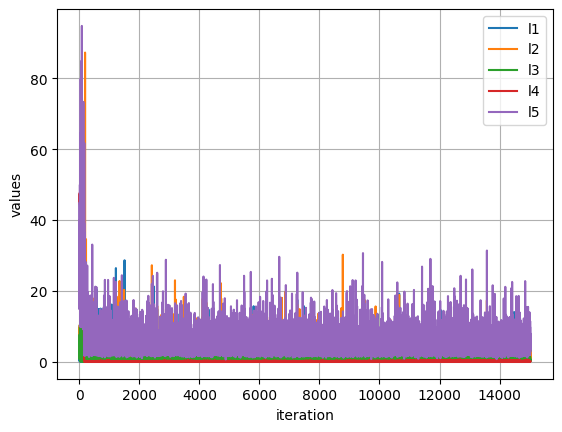

loss_df:               l1         l2         l3         l4         l5
0      1.223951   2.044842   1.620816  47.456020  14.991608
1      6.306578  12.761678  11.439853  43.466827  54.988754
2      2.205029   1.658924   2.924527  45.940620  30.009096
3      1.223116   1.858267   2.231540  46.436893  24.946318
4      1.736516   0.827966   2.531964  46.930988  19.972198
...         ...        ...        ...        ...        ...
15024  1.489157   1.802900   0.639288   0.164812   6.075891
15025  0.963456   0.558331   0.209391   0.221491   1.460373
15026  1.875990   1.504089   0.511535   0.213687   6.563299
15027  3.785004   2.590892   0.573199   0.058226  12.726121
15028  4.898591   2.040294   0.399707   0.143320   7.002266

[15029 rows x 5 columns]


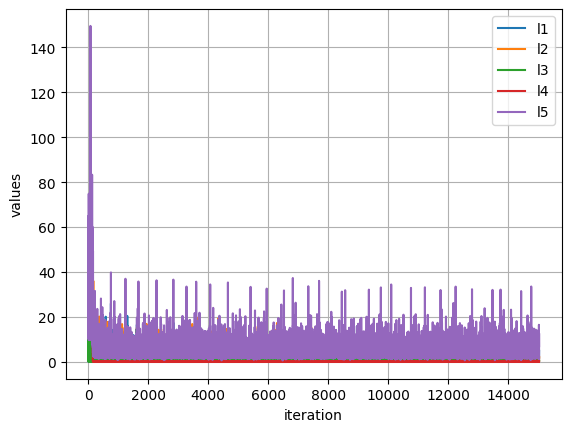

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt

MODEL_HOME = "~/Downloads"
loss_dir = os.path.expanduser(MODEL_HOME)
for fname in ["/train_loss_latest.csv", "/val_loss_latest.csv"]:
    loss_df = pd.read_csv(loss_dir + fname, index_col=0)
    print("loss_df: ", loss_df)
    for col in loss_df.columns:
        # if col == "l1" or col == "l2": #or col == "l5":
        plt.plot(loss_df[col], label=col)
    plt.xlabel("iteration")
    plt.ylabel("values")
    plt.legend()
    plt.grid(True)
    plt.show()